**Подключение билиотек**

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, dummy

**Объявление переменных, содержащих
адреса, названия листов**

In [25]:
NAME = "DataSet_практика.xlsx"
SALES = "Продажи"
PRODUCTS = "Товары"
PARTNERS = "Контрагенты"
ID_PRODUCT = 'Товар ID'
ANALYSIS = "ANALYSIS"

ANALYSIS_PARTNERS_BY_REGION = "./ANALYSIS_PARTNERS_BY_REGION"

**Функция получения данных из листа и таблицы Excel**

In [26]:
def get_df_from_excel(name_file, name_list):
    excel = pd.ExcelFile(name_file)
    return excel.parse(name_list)

**Функция записи данных в таблицу на указанный лист**

In [27]:
def export_df_in_excel(name_file,name_list , df):
    df.to_excel(name_file, sheet_name=name_list)


**import данных из Excel**

In [28]:
df_sales = get_df_from_excel(NAME, SALES)
df_products = get_df_from_excel(NAME, PRODUCTS)
df_part = get_df_from_excel(NAME, PARTNERS)

In [29]:
df_sales.isnull().values.any()

True

In [30]:
df_sales.isnull().any()

Номер заказа            False
Возврат                 False
Дата заказа             False
Дата отправки           False
Режим отправки          False
Факты.Контрагент ID      True
Факты.Товар ID           True
Продажи, руб             True
Продажи, шт              True
Скидка                  False
Маржинальная прибыль     True
dtype: bool

In [31]:
df_sales.isna().sum()

Номер заказа              0
Возврат                   0
Дата заказа               0
Дата отправки             0
Режим отправки            0
Факты.Контрагент ID      90
Факты.Товар ID           51
Продажи, руб            195
Продажи, шт              21
Скидка                    0
Маржинальная прибыль     18
dtype: int64

In [32]:
df_sales.dropna(inplace=True) #clnt00000390

**Изменения имен столбцов, убираю слово** *факт*

In [33]:
df_sales.rename(columns = {'Факты.Контрагент ID':'Контрагент ID','Факты.Товар ID':'Товар ID'}, inplace= True)

**Просмотр названий столбцов**

In [34]:
print(df_sales.columns)

Index(['Номер заказа', 'Возврат', 'Дата заказа', 'Дата отправки',
       'Режим отправки', 'Контрагент ID', 'Товар ID', 'Продажи, руб',
       'Продажи, шт', 'Скидка', 'Маржинальная прибыль'],
      dtype='object')


In [35]:
print(df_products.columns)

Index(['Товар ID', 'Категория', 'Под-Категория', 'Товар'], dtype='object')


In [36]:
print(df_part.columns)

Index(['Контрагент ID', 'Сегмент', 'Контрагент', 'Страна', 'Регион', 'Город',
       'Количество контрагентов', 'Повторения регионов', 'Повторение города'],
      dtype='object')


**Изменение названий столбцов на единные в самом Excel**

In [37]:
export_df_in_excel(NAME, SALES, df_products)

In [38]:
df_sales_clear = df_sales

**Блок подсчёта выручке в регионах и сортировке**

In [39]:
id_contr = 'Контрагент ID'
name_spend ='Продажи, руб'
name_marj = 'Маржинальная прибыль'
name_city = 'Город'


df_result = df_part.merge(df_sales,how = 'inner', left_on= 'Контрагент ID', right_on = 'Контрагент ID')
unique_df_reg = df_result['Регион'].unique()
df_total = pd.DataFrame(columns=[name_city, name_spend])
for row in unique_df_reg:
    help = [str(row)]
    res_sum_sale = df_result.loc[df_result['Регион'].isin(help)][name_spend].sum()
    new_row = {
        name_city: row,
        name_spend: res_sum_sale
    }

    df_total = df_total.append(new_row, ignore_index= True)

df_total =  df_total.sort_values(by = name_spend, ascending=False)
export_df_in_excel('Analysis.xlsx', 'region', df_total)

**Отрисовка диаграммы по выручке регионы**


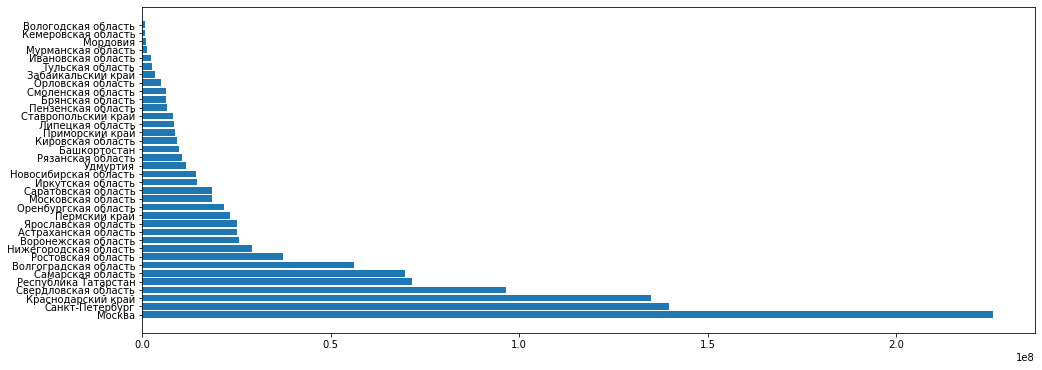

In [40]:

df_to_diagram = get_df_from_excel('Analysis.xlsx', 'region')
fig, graphic = plt.subplots()
graphic.barh(df_to_diagram['Город'], df_to_diagram['Продажи, руб'])
fig.set_figwidth(16)
fig.set_figheight(6)
plt.show()

*в разработке*

In [41]:
df_working = df_products.merge(df_sales, how = 'outer', left_on=ID_PRODUCT, right_on=ID_PRODUCT)
df_working.sort_values(ID_PRODUCT, inplace= True)
df_working = df_working.groupby([ID_PRODUCT, ])[['Продажи, шт']].sum()
df_working.sort_values('Продажи, шт', inplace=True, ascending= False)
df_working = df_working.reset_index()
df_working.sort_values('Продажи, шт', inplace = True, ascending=False)
df_working

,Товар ID,"Продажи, шт"
0,PROD0000219,75.0
1,PROD0000316,70.0
2,PROD0000303,67.0
3,PROD0000479,64.0
4,PROD0000928,64.0
...,...,...
1865,PROD0000453,0.0
1864,PROD0001554,0.0
1863,PROD0001400,0.0
1862,PROD0001487,0.0


In [42]:
df_sales['Чистая продажа, руб'] = df_sales['Продажи, руб'] / ((1 - df_sales['Скидка']))  
df_sales['Цена товара'] = df_sales['Чистая продажа, руб'] / df_sales['Продажи, шт']

In [43]:
df_sales


,Номер заказа,Возврат,Дата заказа,Дата отправки,Режим отправки,Контрагент ID,Товар ID,"Продажи, руб","Продажи, шт",Скидка,Маржинальная прибыль,"Чистая продажа, руб",Цена товара
0,2014-100279,Нет,2015-09-10,2015-09-14,Стандарт,CLNT0000422,PROD0000870,11190.0,2.0,0.0,5371.20,11190.0,5595.0
1,2014-100293,Нет,2015-09-14,2015-09-18,Стандарт,CLNT0000784,PROD0000646,45528.0,6.0,0.2,15934.80,56910.0,9485.0
2,2014-100328,Нет,2015-07-28,2015-08-03,Стандарт,CLNT0000342,PROD0000187,1964.0,1.0,0.2,662.85,2455.0,2455.0
3,2014-100363,Нет,2015-10-08,2015-10-15,Стандарт,CLNT0000146,PROD0001095,1184.0,2.0,0.2,414.40,1480.0,740.0
4,2014-100363,Нет,2015-10-08,2015-10-15,Стандарт,CLNT0000146,PROD0001616,9504.0,3.0,0.2,3445.20,11880.0,3960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10288,2018-169929,Нет,2019-03-25,2019-03-28,Первый класс,CLNT0000182,PROD0000869,19950.0,5.0,0.0,5187.00,19950.0,3990.0
10289,2018-169978,Нет,2019-06-24,2019-06-28,Стандарт,CLNT0000575,PROD0000293,135882.0,2.0,0.1,24156.80,150980.0,75490.0
10290,2018-169978,Нет,2019-06-24,2019-06-28,Стандарт,CLNT0000575,PROD0001131,7188.0,3.0,0.2,2425.95,8985.0,2995.0
10291,2018-169999,Нет,2018-12-19,2018-12-26,Стандарт,CLNT0000013,PROD0000549,5784.0,3.0,0.2,1879.80,7230.0,2410.0


In [44]:
df_sales_analysis = pd.pivot_table(df_sales, values=['Чистая продажа, руб','Продажи, шт','Маржинальная прибыль','Цена товара'], index = ["Товар ID"],
                                             aggfunc={ 
                                            'Продажи, шт': [np.median, np.sum],
                                                 'Чистая продажа, руб': np.sum,
                                                   'Цена товара': np.mean,
                                                   'Маржинальная прибыль': np.sum
                                             }
                                   )

In [45]:
df_sales_analysis

Маржинальная прибыль Продажи, шт       Цена товара  \
                             sum      median   sum        mean   
Товар ID                                                         
PROD0000001            -28160.70         2.5  12.0     65490.0   
PROD0000002            963721.00         3.5  51.0    121990.0   
PROD0000003             32200.55         2.0  23.0      3655.0   
PROD0000004           -266380.65         4.0  29.0    174105.0   
PROD0000005             31874.40         5.0  24.0      6990.0   
...                          ...         ...   ...         ...   
PROD0001890             18223.65         3.0   3.0     67495.0   
PROD0001891            -82476.90         3.0   3.0    124965.0   
PROD0001892             27680.80         4.0   4.0     24715.0   
PROD0001893           -187496.25         5.0   5.0    249995.0   
PROD0001894              1837.20         3.0   3.0      7655.0   

            Чистая продажа, руб  
                            sum  
Товар ID                         
PROD0000001            785880.0  
PROD0000002           6221490.0  
PROD0000003             84065.0  
PROD0000004           5049045.0  
PROD0000005            167760.0  
...                         ...  
PROD0001890            202485.0  
PROD0001891            374895.0  
PROD0001892             98860.0  
PROD0001893           1249975.0  
PROD0001894             22965.0  

[1862 rows x 5 columns]

In [46]:
new_name = df_sales_analysis.columns.map(' '.join)
new_name

Index(['Маржинальная прибыль sum', 'Продажи, шт median', 'Продажи, шт sum',
       'Цена товара mean', 'Чистая продажа, руб sum'],
      dtype='object')

In [47]:
df_sales_analysis.columns = new_name
df_sales_analysis.reset_index(inplace=True)
df_sales_analysis.head()

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum"
0,PROD0000001,-28160.70,2.5,12.0,65490.0,785880.0
1,PROD0000002,963721.00,3.5,51.0,121990.0,6221490.0
2,PROD0000003,32200.55,2.0,23.0,3655.0,84065.0
3,PROD0000004,-266380.65,4.0,29.0,174105.0,5049045.0
4,PROD0000005,31874.40,5.0,24.0,6990.0,167760.0


In [48]:
df_sales_analysis['Маржинальная прибыль sum'].sum()

143204540.24999997

In [49]:
total_sale = df_sales_analysis['Чистая продажа, руб sum'].sum()
total_sale

1431766540.0

In [50]:
df_sales_analysis['Доля'] = df_sales_analysis['Чистая продажа, руб sum'] / total_sale * 100

In [51]:
df_sales_analysis['Доля'].sum()

100.0

In [52]:
df_sales_analysis.sort_values(by = ['Чистая продажа, руб sum', 'Продажи, шт median' ], ascending= False, inplace=True)
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593
...,...,...,...,...,...,...,...
237,PROD0000239,-2233.0,2.0,2.0,2030.0,4060.0,0.000284
1850,PROD0001883,1366.8,6.0,6.0,670.0,4020.0,0.000281
1838,PROD0001871,1578.5,2.0,2.0,1925.0,3850.0,0.000269
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226


In [53]:
df_sales_analysis = df_sales_analysis.assign(sum_d = df_sales_analysis['Доля'].cumsum())
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488
...,...,...,...,...,...,...,...,...
237,PROD0000239,-2233.0,2.0,2.0,2030.0,4060.0,0.000284,99.999023
1850,PROD0001883,1366.8,6.0,6.0,670.0,4020.0,0.000281,99.999304
1838,PROD0001871,1578.5,2.0,2.0,1925.0,3850.0,0.000269,99.999573
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799


In [54]:
df_sales_analysis.loc[(df_sales_analysis['sum_d'] <= 80), 'ABC'] = 'A'
df_sales_analysis.loc[(df_sales_analysis['sum_d'] > 80) & (df_sales_analysis['sum_d'] <= 95), 'ABC'] = 'B'
df_sales_analysis.loc[(df_sales_analysis['sum_d'] > 95), 'ABC'] = 'C'
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d,ABC
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526,A
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683,A
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630,A
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895,A
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488,A
...,...,...,...,...,...,...,...,...,...
237,PROD0000239,-2233.0,2.0,2.0,2030.0,4060.0,0.000284,99.999023,C
1850,PROD0001883,1366.8,6.0,6.0,670.0,4020.0,0.000281,99.999304,C
1838,PROD0001871,1578.5,2.0,2.0,1925.0,3850.0,0.000269,99.999573,C
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799,C


In [55]:
export_df_in_excel('Analysis.xlsx', 'ABC_sort_without_nosales_goods' ,df_sales_analysis)

In [56]:
df_sales_analysis['Продажи в следующем периоде'] = (df_sales_analysis['Продажи, шт sum'] + df_sales_analysis['Продажи, шт median']) * df_sales_analysis['Цена товара mean']
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d,ABC,Продажи в следующем периоде
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526,A,41999880.0
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683,A,45276960.0
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630,A,21606830.0
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895,A,21095345.0
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488,A,20165970.0
...,...,...,...,...,...,...,...,...,...,...
237,PROD0000239,-2233.0,2.0,2.0,2030.0,4060.0,0.000284,99.999023,C,8120.0
1850,PROD0001883,1366.8,6.0,6.0,670.0,4020.0,0.000281,99.999304,C,8040.0
1838,PROD0001871,1578.5,2.0,2.0,1925.0,3850.0,0.000269,99.999573,C,7700.0
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799,C,6480.0


In [57]:
total_sale = df_sales_analysis['Продажи в следующем периоде'].sum()
total_sale

1721049601.8917747

In [58]:
df_sales_analysis['Доля_буд'] = df_sales_analysis['Продажи в следующем периоде'] / total_sale * 100
df_sales_analysis.sort_values(by = ['Продажи в следующем периоде', 'Продажи, шт median' ], ascending= False, inplace=True)
df_sales_analysis = df_sales_analysis.assign(sum_d_fut = df_sales_analysis['Доля_буд'].cumsum())
df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] <= 80), 'ABC_future'] = 'A'
df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] > 80) & (df_sales_analysis['sum_d'] <= 95), 'ABC_future'] = 'B'
df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] > 95), 'ABC_future'] = 'C'
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d,ABC,Продажи в следующем периоде,Доля_буд,sum_d_fut,ABC_future
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683,A,45276960.0,2.630776,2.630776,A
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526,A,41999880.0,2.440364,5.071140,A
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630,A,21606830.0,1.255445,6.326585,A
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895,A,21095345.0,1.225726,7.552311,A
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488,A,20165970.0,1.171725,8.724036,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,PROD0001853,1736.0,2.0,4.0,1240.0,4960.0,0.000346,99.997472,C,7440.0,0.000432,99.998522,C
801,PROD0000808,1702.0,2.5,5.0,920.0,4600.0,0.000321,99.998137,C,6900.0,0.000401,99.998923,C
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799,C,6480.0,0.000377,99.999299,C
1245,PROD0001257,1050.0,2.5,5.0,840.0,4200.0,0.000293,99.998739,C,6300.0,0.000366,99.999665,C


In [59]:
df_sales_analysis.loc[(df_sales_analysis['ABC'] != df_sales_analysis['ABC_future']), 'Изменение класса'] = 1
df_sales_analysis.loc[(df_sales_analysis['ABC'] == df_sales_analysis['ABC_future']), 'Изменение класса'] = 0    
df_sales_analysis                

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d,ABC,Продажи в следующем периоде,Доля_буд,sum_d_fut,ABC_future,Изменение класса
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683,A,45276960.0,2.630776,2.630776,A,0.0
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526,A,41999880.0,2.440364,5.071140,A,0.0
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630,A,21606830.0,1.255445,6.326585,A,0.0
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895,A,21095345.0,1.225726,7.552311,A,0.0
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488,A,20165970.0,1.171725,8.724036,A,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,PROD0001853,1736.0,2.0,4.0,1240.0,4960.0,0.000346,99.997472,C,7440.0,0.000432,99.998522,C,0.0
801,PROD0000808,1702.0,2.5,5.0,920.0,4600.0,0.000321,99.998137,C,6900.0,0.000401,99.998923,C,0.0
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799,C,6480.0,0.000377,99.999299,C,0.0
1245,PROD0001257,1050.0,2.5,5.0,840.0,4200.0,0.000293,99.998739,C,6300.0,0.000366,99.999665,C,0.0


In [60]:
df_sales_analysis['Изменение класса'].sum()

44.0

In [71]:
df_sales_analysis.loc[(df_sales_analysis['sum_d'] <= 80), 'class'] = '0'
df_sales_analysis.loc[(df_sales_analysis['sum_d'] > 80) & (df_sales_analysis['sum_d'] <= 95), 'class'] = '1'
df_sales_analysis.loc[(df_sales_analysis['sum_d'] > 95), 'class'] = '2'

df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] <= 80), 'class_fut'] = '0'
df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] > 80) & (df_sales_analysis['sum_d'] <= 95), 'class_fut'] = '1'
df_sales_analysis.loc[(df_sales_analysis['sum_d_fut'] > 95), 'class_fut'] = '2'
df_sales_analysis

,Товар ID,Маржинальная прибыль sum,"Продажи, шт median","Продажи, шт sum",Цена товара mean,"Чистая продажа, руб sum",Доля,sum_d,ABC,Продажи в следующем периоде,Доля_буд,sum_d_fut,ABC_future,Изменение класса,class,class_fut
1411,PROD0001430,-905539.2,6.0,6.0,3773080.0,22638480.0,1.581157,4.025683,A,45276960.0,2.630776,2.630776,A,0.0,0,0
1388,PROD0001406,12599964.0,4.0,20.0,1749995.0,34999900.0,2.444526,2.444526,A,41999880.0,2.440364,5.071140,A,0.0,0,0
450,PROD0000454,3876519.5,3.0,31.0,635495.0,19700345.0,1.375947,5.401630,A,21606830.0,1.255445,6.326585,A,0.0,0,0
316,PROD0000318,-939083.1,4.0,27.0,680495.0,18373365.0,1.283265,6.684895,A,21095345.0,1.225726,7.552311,A,0.0,0,0
692,PROD0000698,380490.0,5.0,48.0,380490.0,18263520.0,1.275593,7.960488,A,20165970.0,1.171725,8.724036,A,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,PROD0001853,1736.0,2.0,4.0,1240.0,4960.0,0.000346,99.997472,C,7440.0,0.000432,99.998522,C,0.0,2,2
801,PROD0000808,1702.0,2.5,5.0,920.0,4600.0,0.000321,99.998137,C,6900.0,0.000401,99.998923,C,0.0,2,2
1747,PROD0001779,1555.2,1.0,1.0,3240.0,3240.0,0.000226,99.999799,C,6480.0,0.000377,99.999299,C,0.0,2,2
1245,PROD0001257,1050.0,2.5,5.0,840.0,4200.0,0.000293,99.998739,C,6300.0,0.000366,99.999665,C,0.0,2,2


In [140]:
factors = ['Цена товара mean', 'Продажи, шт median', 'Маржинальная прибыль sum']
target_column = 'class'


In [141]:
alter_df = df_sales_analysis[factors + [target_column]]

In [142]:
alter_df = alter_df.sample(frac = 1)
alter_df

,Цена товара mean,"Продажи, шт median",Маржинальная прибыль sum,class
1595,8370.0,3.0,51224.40,2
1396,3240.0,3.0,18532.80,2
370,47975.0,3.0,58529.50,0
312,4995.0,3.0,27422.55,2
847,178910.0,2.0,357820.00,0
...,...,...,...,...
679,1290.0,2.5,4308.60,2
812,61495.0,3.0,-237370.70,0
1623,67975.0,2.0,114198.00,1
754,174995.0,3.5,41998.80,0


In [143]:
X = alter_df[factors]
y = alter_df[target_column]

In [144]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X ,y)
model = RandomForestClassifier(n_estimators=20)
best_model = model.fit(X_train, y_train)
score_RF = best_model.score(X_test, y_test)
print("Score:", best_model.score(X_test, y_test))

Score: 0.8497854077253219


In [146]:
a = 1223213211
b = 1002231
c = 132
print(best_model.predict_proba([[a,b,c]]))
print(best_model.predict([[a,b,c]]))

[[0.7 0.3 0. ]]
['0']


In [150]:
 df_h = df_sales_clear.sort_values(by = ['Скидка', 'Контрагент ID'], ascending= False)
 df_h.head(100)   

,Номер заказа,Возврат,Дата заказа,Дата отправки,Режим отправки,Контрагент ID,Товар ID,"Продажи, руб","Продажи, шт",Скидка,Маржинальная прибыль,"Чистая продажа, руб",Цена товара
1058,2015-119172,Нет,2015-11-11,2015-11-15,Стандарт,CLNT0000792,PROD0000928,52290.0,9.0,0.8,-86278.50,261450.0,29050.0
7338,2017-162404,Нет,2018-01-23,2018-01-27,Стандарт,CLNT0000784,PROD0001414,5708.0,4.0,0.8,-9418.20,28540.0,7135.0
7317,2017-162103,Нет,2018-05-13,2018-05-17,Стандарт,CLNT0000777,PROD0000464,1568.0,2.0,0.8,-2352.00,7840.0,3920.0
6566,2017-144540,Нет,2018-03-05,2018-03-10,Стандарт,CLNT0000776,PROD0000554,31395.0,3.0,0.8,-83196.75,156975.0,52325.0
842,2015-112200,Нет,2016-05-22,2016-05-28,Стандарт,CLNT0000772,PROD0001241,4990.0,5.0,0.8,-8233.50,24950.0,4990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,2017-139234,Нет,2017-11-06,2017-11-10,Стандарт,CLNT0000541,PROD0000388,1604.0,2.0,0.8,-2646.60,8020.0,4010.0
4354,2016-156377,Нет,2017-06-30,2017-07-05,Стандарт,CLNT0000540,PROD0001214,1828.0,4.0,0.8,-2924.80,9140.0,2285.0
1110,2015-120852,Нет,2016-06-20,2016-06-25,Стандарт,CLNT0000539,PROD0000540,9716.0,2.0,0.8,-24775.80,48580.0,24290.0
5829,2017-126627,Нет,2018-04-10,2018-04-12,Первый класс,CLNT0000539,PROD0000807,8196.0,2.0,0.8,-13113.60,40980.0,20490.0


In [158]:
df_sales_bad = pd.pivot_table(df_sales, index = ["Товар ID"],
                                             aggfunc={
                                                   'Маржинальная прибыль': np.sum
                                             }
                                   )

In [159]:
df_sales_bad

,Маржинальная прибыль
Товар ID,
PROD0000001,-28160.70
PROD0000002,963721.00
PROD0000003,32200.55
PROD0000004,-266380.65
PROD0000005,31874.40
...,...
PROD0001890,18223.65
PROD0001891,-82476.90
PROD0001892,27680.80


In [160]:
df_sales_bad=df_sales_bad.loc[df_sales_bad['Маржинальная прибыль'] < 0]

In [161]:
df_sales_bad

,Маржинальная прибыль
Товар ID,
PROD0000001,-28160.70
PROD0000004,-266380.65
PROD0000011,-225121.50
PROD0000027,-334772.40
PROD0000028,-34785.10
...,...
PROD0001880,-874.50
PROD0001881,-125993.70
PROD0001888,-914.75


In [163]:
df_ID_ABC = df_sales_analysis[['Товар ID', 'ABC']]
df_ID_ABC

,Товар ID,ABC
1411,PROD0001430,A
1388,PROD0001406,A
450,PROD0000454,A
316,PROD0000318,A
692,PROD0000698,A
...,...,...
1820,PROD0001853,C
801,PROD0000808,C
1747,PROD0001779,C
1245,PROD0001257,C


In [166]:
df_pivot_id_abc_prod = pd.merge( df_products,df_ID_ABC, how ='left', on= 'Товар ID')
df_pivot_id_abc_prod

,Товар ID,Категория,Под-Категория,Товар,ABC
0,PROD0001112,Офисные принадлежности,Бумага,"""While you Were Out"" Message Book, One Form pe...",C
1,PROD0001680,Офисные принадлежности,Конверты,#6 3/4 Gummed Flap White Envelopes,C
2,PROD0000320,Офисные принадлежности,Конверты,"#10 Gummed Flap White Envelopes, 100/Box",C
3,PROD0001496,Офисные принадлежности,Конверты,#10 Self-Seal White Envelopes,C
4,PROD0001375,Офисные принадлежности,Конверты,"#10 White Business Envelopes,4 1/8 x 9 1/2",B
...,...,...,...,...,...
1889,PROD0001855,Технологии,Оборудование,Zebra GK420t Direct Thermal/Thermal Transfer P...,A
1890,PROD0000674,Технологии,Оборудование,Zebra GX420t Direct Thermal/Thermal Transfer P...,A
1891,PROD0000492,Офисные принадлежности,Произведения искусства,Zebra Zazzle Fluorescent Highlighters,C
1892,PROD0001744,Технологии,Оборудование,Zebra ZM400 Thermal Label Printer,A


In [169]:
df_pivot_noempty = df_pivot_id_abc_prod[df_pivot_id_abc_prod['ABC'].isna()]
df_pivot_noempty = df_pivot_noempty.fillna('нет данных')
df_pivot_noempty

,Товар ID,Категория,Под-Категория,Товар,ABC
34,PROD0001514,Технологии,Телефоны,Aastra 6757i CT Wireless VoIP phone,нет данных
95,PROD0000568,Офисные принадлежности,Бумага,Adams Telephone Message Book W/Dividers/Space ...,нет данных
158,PROD0001436,Технологии,Телефоны,AT&T CL2909,нет данных
250,PROD0001580,Офисные принадлежности,Произведения искусства,Avery Hi-Liter Comfort Grip Fluorescent Highli...,нет данных
295,PROD0000864,Офисные принадлежности,Техника,"Belkin 325VA UPS Surge Protector, 6'",нет данных
496,PROD0001339,Мебель,Интерьер,DAX Solid Wood Frames,нет данных
556,PROD0000979,Мебель,Интерьер,"Eldon 200 Class Desk Accessories, Black",нет данных
561,PROD0001761,Мебель,Интерьер,Eldon 500 Class Desk Accessories,нет данных
572,PROD0001281,Мебель,Интерьер,"Eldon Executive Woodline II Desk Accessories, ...",нет данных
629,PROD0001615,Мебель,Интерьер,"Executive Impressions 13"" Chairman Wall Clock",нет данных


In [172]:
export_df_in_excel('Analysis.xlsx','Продажи',df_sales_clear)
export_df_in_excel('Analysis.xlsx','Товары',df_products)
export_df_in_excel('Analysis.xlsx','Контрагенты',df_part)
export_df_in_excel('Analysis.xlsx','Продажи с анализом ABC',df_sales_analysis)
export_df_in_excel('Analysis.xlsx','Только ABC',df_ID_ABC)
export_df_in_excel('Analysis.xlsx','Товары ABC ID', df_pivot_id_abc_prod)
export_df_in_excel('Analysis.xlsx','Нет данных продаж', df_pivot_noempty)